In [1]:
import warnings
warnings.simplefilter("ignore")
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
from scipy.io import savemat
from scipy.fft import fftfreq, fftshift, fftn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pylab import *

In [2]:
class NeuralNet:
    # Initialize the class
    def __init__(self, t_u, x_u, layers, kappa, lt, ut, acts=0):

        self.scale = tf.reduce_max(tf.abs(x_u)) / 2
        x_u2 = x_u / self.scale
        actv = [tf.tanh, tf.sin]

        self.t_u = t_u
        self.x_u = x_u2
        self.datatype = t_u.dtype

        self.lt = lt
        self.ut = ut

        self.layers = layers
        self.kappa = kappa

        # determine the activation function to use
        self.actv = actv[acts]

        # Initialize NNs
        self.weights, self.biases = self.initialize_NN(layers)

        # Create a list including all training variables
        self.train_variables = self.weights + self.biases
        # Key point: anything updates in train_variables will be
        #            automatically updated in the original tf.Variable

        # define the loss function
        self.loss0 = self.scale ** 2
        self.loss = []
        self.loss_0 = self.loss_NN()

        self.optimizer_Adam = tf.optimizers.Adam()

    '''
    Functions used to establish the initial neural network
    ===============================================================
    '''

    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)

        for l in range(0, num_layers - 1):
            W = self.MPL_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=self.datatype))
            weights.append(W)
            biases.append(b)
        return weights, biases

    def MPL_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
        return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev, dtype=self.datatype))

    def get_params(self):
        return (self.weights, self.biases)

    '''
    Functions used to building the physics-informed contrainst and loss
    ===============================================================
    '''

    def neural_net(self, X):
        weights = self.weights
        biases = self.biases

        num_layers = len(weights) + 1

        H = 2.0 * tf.math.divide(
                    tf.math.subtract(X, tf.transpose(self.lt)), 
                    tf.transpose(tf.math.subtract(self.ut, self.lt))) \
            - 1.0

        W = weights[0]
        b = biases[0]
        H = self.actv(tf.add(self.kappa * tf.matmul(H, W), b))

        for l in range(1, num_layers - 2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    @tf.function(reduce_retracing=True)
    # calculate the physics-informed loss function
    def loss_NN(self):
        self.x_pred = self.neural_net(self.t_u)
        loss = tf.reduce_mean(tf.square(self.x_u - self.x_pred))
        return loss

    '''
    Functions used to define ADAM optimizers
    ===============================================================
    '''

    # define the function to apply the ADAM optimizer
    def adam_function(self):
        @tf.function(reduce_retracing=True)
        def f1():
            # calculate the loss
            loss_norm = self.loss_NN()
            loss_value = loss_norm * self.loss0
            # store loss value so we can retrieve later
            tf.py_function(f1.loss.append, inp=[loss_value], Tout=[])

            # print out iteration & loss
            f1.iter.assign_add(1)

            str_iter = tf.strings.as_string([f1.iter])
            str_loss = tf.strings.as_string([loss_value], precision=4, scientific=True)

            str_print = tf.strings.join(["Mode: Adam", "Iter: ", str_iter[0],
                                         ", loss: ", str_loss[0]])
            tf.cond(
                f1.iter % 10 == 0,
                lambda: tf.print(str_print),
                lambda: tf.constant(True)  # return arbitrary for non-printing case
            )
            return loss_norm

        f1.iter = tf.Variable(0)
        f1.term = []
        f1.loss = []
        return f1

    def Adam_optimizer(self, nIter):
        varlist = self.train_variables
        func_adam = self.adam_function()
        for it in range(nIter):
            tf.keras.optimizers.Adam(func_adam, varlist)
            #self.optimizer_Adam.minimize(func_adam, varlist)
        return func_adam

    '''
    Functions used to define L-BFGS optimizers
    ===============================================================
    '''

    # A factory to create a function required by tfp.optimizer.lbfgs_minimize.
    def Lbfgs_function(self, varlist):
        # obtain the shapes of all trainable parameters in the model
        shapes = tf.shape_n(varlist)
        n_tensors = len(shapes)

        # we'll use tf.dynamic_stitch and tf.dynamic_partition later, so we need to
        # prepare required information first
        count = 0
        idx = []  # stitch indices
        part = []  # partition indices

        for i, shape in enumerate(shapes):
            n = np.prod(shape)
            idx.append(tf.reshape(tf.range(count, count + n, dtype=tf.int32), shape))
            part.extend([i] * n)
            count += n

        part = tf.constant(part)

        def assign_new_model_parameters(params_1d):
            # A function updating the model's parameters with a 1D tf.Tensor.
            # Sub-function under function of class not need to input self

            params = tf.dynamic_partition(params_1d, part, n_tensors)
            for i, (shape, param) in enumerate(zip(shapes, params)):
                varlist[i].assign(tf.reshape(param, shape))

        @tf.function(reduce_retracing=True)
        def f2(params_1d):
            # A function that can be used by tfp.optimizer.lbfgs_minimize.
            # This function is created by function_factory.
            # Sub-function under function of class not need to input self

            # use GradientTape so that we can calculate the gradient of loss w.r.t. parameters
            with tf.GradientTape() as tape:
                # update the parameters in the model
                # this step is critical for self-defined function for L-BFGS
                assign_new_model_parameters(params_1d)
                # calculate the loss
                loss_norm = self.loss_NN()
                loss_value = loss_norm * self.loss0

            # calculate gradients and convert to 1D tf.Tensor
            grads = tape.gradient(loss_norm, varlist)
            grads = tf.dynamic_stitch(idx, grads)

            # store loss value so we can retrieve later
            tf.py_function(f2.loss.append, inp=[loss_value], Tout=[])

            # print out iteration & loss
            f2.iter.assign_add(1)

            str_iter = tf.strings.as_string([f2.iter])
            str_loss = tf.strings.as_string([loss_value], precision=4, scientific=True)

            str_print = tf.strings.join(["Mode: LBFGS", "Iter: ", str_iter[0],
                                         ", loss: ", str_loss[0]])
            tf.cond(
                f2.iter % 3000 == 0,
                lambda: tf.print(str_print),
                lambda: tf.constant(True)  # return arbitrary for non-printing case
            )

            return loss_value, grads

        # store these information as members so we can use them outside the scope
        f2.iter = tf.Variable(0)
        f2.idx = idx
        f2.part = part
        f2.shapes = shapes
        f2.assign_new_model_parameters = assign_new_model_parameters
        f2.loss = []

        return f2

    # define the function to apply the L-BFGS optimizer
    def Lbfgs_optimizer(self, nIter, varlist):

        func = self.Lbfgs_function(varlist)

        # convert initial model parameters to a 1D tf.Tensor
        init_params = tf.dynamic_stitch(func.idx, varlist)

        max_nIter = tf.cast(nIter / 3, dtype=tf.int32)

        # train the model with L-BFGS solver
        results = tfp.optimizer.lbfgs_minimize(
            value_and_gradients_function=func, initial_position=init_params,
            tolerance=1e-11, max_iterations=max_nIter)

        # after training, the final optimized parameters are still in results.position
        # so we have to manually put them back to the model
        func.assign_new_model_parameters(results.position)

        return func

    '''
    Function used for training the model
    ===============================================================
    '''

    def train(self, nIter, idxOpt):
        if idxOpt == 1:
            # mode 1: running the Adam optimization
            func_adam = self.Adam_optimizer(nIter)
            self.loss += func_adam.loss
        elif idxOpt == 2:
            # mode 2: running the Lbfgs optimization
            func_bfgs = self.Lbfgs_optimizer(nIter, self.train_variables)
            self.loss += func_bfgs.loss

    # @tf.function
    def predict(self, t):
        x_p = self.neural_net(t) * self.scale
        return x_p

    


In [ ]:
class MultistageNeuralNetwork:
    '''MultistageNeuralNetwork is the multi-stage model used for predicting
    high-dimensional function outputs through regression. The network takes as parameters the input dataset,
    an n-dimensional square tensor of grid points, a list of labels corresponding to function outputs at each grid point,
    a number of stages for the MSNN, a number of hidden layers for each stage, and a number of hidden nodes in each
    hidden layer of each stage of the MSNN'''
    def __init__(self, x_train, num_stages, num_hidden_layers, num_hidden_nodes):
        # MSNN setup
        self.dim = x_train.shape[-1]                                 # number of dimensions
        self.N = int(round(x_train.shape[0] ** (1/self.dim)))        # number of points per dimension
        self.stages = [None] * num_stages                           # Number of stages for MSNN
        self.layers = [self.dim] + ([num_hidden_nodes] * num_hidden_layers) + [1] # NN architecture for each stage 
        self.lt = [tf.math.reduce_min(x_train[:, i]) for i in range(x_train.shape[-1])] # min of each dim
        self.ut = [tf.math.reduce_max(x_train[:, i]) for i in range(x_train.shape[-1])] # max of each dim
    
    # @staticmethod
    # def sample(x_train, y_train, step):
    #     '''sample returns a subset of evenly-spaced data points from dataset/labels by converting
    #     both into a grid format and taking slices of the grid at specified intervals'''
    #     dim = x_train.shape[-1]
    #     N = int(round(x_train.shape[0] ** (1/dim)))  
    #     reshaped_x = tf.reshape(x_train, [N] * dim + [dim])
    #     reshaped_y = tf.reshape(y_train, [N] * dim)

    #     slices = tuple(slice(0, N, step) for _ in range(dim))

    #     sampled_grid = reshaped_x[slices + (slice(None),)]
    #     sampled_y = reshaped_y[slices]

    #     sampled_points = tf.reshape(sampled_grid, (-1, dim))
    #     sampled_y = tf.reshape(sampled_y, (-1, 1))
    #     print(f"Sampled data size: {sampled_points.shape}, Sampled labels size: {sampled_y.shape}")
    #     return sampled_points, sampled_y
    

    def train(self, x_train, y_train, stage, kappa, iters):
        act = 0 if stage == 0 else 1
        lt = [tf.cast(tf.math.reduce_min(x_train[:, i]).numpy(), dtype=tf.float64) for i in range(x_train.shape[-1])]
        ut = [tf.cast(tf.math.reduce_max(x_train[:, i]).numpy(), dtype=tf.float64) for i in range(x_train.shape[-1])]
        self.stages[stage] = NeuralNet(x_train, y_train, self.layers, kappa=kappa, lt=lt, ut=ut, acts=act)
        print(f"Adam Training for stage: {stage}")
        self.stages[stage].train(iters[0], 1)     # mode 1 use Adam
        print(f"L-BFGS Training for stage: {stage}")
        self.stages[stage].train(iters[1], 2)    # mode 2 use L-bfgs
    
    @staticmethod
    def fftn_(x_train, residue):
        dim = x_train.shape[-1]
        N_train = int(round(x_train.shape[0] ** (1/dim))) 
        g = residue.numpy()

        GG = g.reshape([N_train] * dim)
        G = fftn(GG)
        G_shifted = fftshift(G)

        N = len(G)
        # Total time range
        total_time_range = 2  # from -1 to 1

        # Calculate the sample rate
        sample_rate = N / total_time_range

        # # Perform FFT
        half_N = N // 2
        T = 1.0 / sample_rate
        idxs = tuple(slice(half_N, N, 1) for _ in range(dim))
        G_pos = G_shifted[idxs]
        freqs = [fftshift(fftfreq(GG.shape[i], d=T)) for i in range(len(GG.shape))]

        # freq_x_pos = freq_x[half_N:]
        # freq_y_pos = freq_y[half_N:]
        freq_pos = [freqs[i][half_N:] for i in range(len(freqs))]

        # Identify the dominant frequency
        magnitude_spectrum = np.abs(G_pos)
        max_idx = np.unravel_index(np.argmax(magnitude_spectrum), magnitude_spectrum.shape)
        dominant_freqs = [freq_pos[i][max_idx[i]] for i in range(len(freq_pos))]
        magnitude = magnitude_spectrum[max_idx] / (N ** dim) # normalize magnitude
        dominant_freq = max(dominant_freqs)
        print(f"Sample rate = {sample_rate} Hz, Dominant Frequency = {dominant_freq} Hz, Magnitude = {magnitude}")
        kappa_f =  2 * np.pi * dominant_freq if dominant_freq > 0 else 2 * np.pi
        print(f"New Kappa: {kappa_f}")
        return kappa_f
    

In [4]:
# Functions for creating data
def create_ds(dims, lo, hi, N):
    dimensions = [np.linspace(lo, hi, N)] * dims
    mesh = np.meshgrid(*dimensions, indexing='xy')
    mesh_points = np.stack([m.flatten() for m in mesh], axis=-1)
    mesh_tf = tf.cast(mesh_points, dtype=tf.float64)
    return mesh_tf

def example_1d_fun(x_train):
    y_train = x_train ** 3 / (0.01 + x_train ** 4)
    return y_train

def example_2d_fun(x_train1, x_train2):
    y_train = (np.sin(x_train1 + 1) - 0.5 * np.sin(x_train1))*(1 - x_train2 ** 2)
    return y_train

def poisson(x_train):
    N_f = x_train.shape[0]
    dim = x_train.shape[-1]
    coeffs = 1 # used to be random from 1 to dim - 1
    const_2 = 1
    x_radius = 1

    xf = x_train.numpy() # used to be random points of size (N_f, args.dim) normalized by sqrt(sum(squares))
    x = xf

    u1 = x_radius**2 - np.sum(x**2, 1, keepdims=True)
    du1_dx = -2 * x
    d2u1_dx2 = -2

    x1, x2 = x[:, :-1], x[:, 1:]
    u2 = coeffs * np.sin(x1 + const_2 * np.cos(x2) + x2 * np.cos(x1))
    u2 = np.sum(u2, 1, keepdims=True)
    du2_dx_part1 = coeffs * np.cos(x1 + const_2 * np.cos(x2) + x2 * np.cos(x1)) * \
            (1 - x2 * np.sin(x1))
    du2_dx_part2 = coeffs * np.cos(x1 + const_2 * np.cos(x2) + x2 * np.cos(x1)) * \
            (-const_2 * np.sin(x2) + np.cos(x1))
    du2_dx = np.zeros((N_f, dim))
    du2_dx[:, :-1] += du2_dx_part1
    du2_dx[:, 1:] += du2_dx_part2
    d2u2_dx2_part1 = -coeffs * np.sin(x1 + const_2 * np.cos(x2) + x2 * np.cos(x1)) * (1 - x2 * np.sin(x1))**2 + \
            coeffs * np.cos(x1 + const_2 * np.cos(x2) + x2 * np.cos(x1)) * (- x2 * np.cos(x1))
    d2u2_dx2_part2 = -coeffs * np.sin(x1 + const_2 * np.cos(x2) + x2 * np.cos(x1)) * (-const_2 * np.sin(x2) + np.cos(x1))**2 + \
            coeffs * np.cos(x1 + const_2 * np.cos(x2) + x2 * np.cos(x1)) * (-const_2 * np.cos(x2))
    d2u2_dx2 = np.zeros((N_f, dim))
    d2u2_dx2[:, :-1] += d2u2_dx2_part1
    d2u2_dx2[:, 1:] += d2u2_dx2_part2
    ff = u1 * d2u2_dx2 + 2 * du1_dx * du2_dx + u2 * d2u1_dx2
    ff = np.sum(ff, 1)
    u = (u1 * u2).reshape(-1)
    ff = ff + np.sin(u)

    ff = tf.convert_to_tensor(ff, dtype=tf.float64)  
    return ff

In [5]:
# Create train and eval data
dim = 1
N_train = 1501
N_eval = 8000
x_train = create_ds(dim, -1.02, 1.02, N_train)
y_train = tf.reshape(example_1d_fun(x_train), [len(x_train), 1])
x_eval = create_ds(dim, -1.02, 1.02, N_eval)
y_eval = tf.reshape(example_1d_fun(x_eval), [len(x_eval), 1])

(1501, 1) (1501, 1)


In [ ]:
# Compute Prediction for one dataset (dim = 2)
num_stages = 4
num_hidden_layers = 3
num_hidden_nodes = 20
# sample_sizes = list([1, 3, 6, 6, 24, 24, 120, 120][:num_stages])[::-1] 
sample_sizes = [1501, 1501, 4801, 4801] # sampling schedule - change based on dimensionality of problem
# Find indices where the value changes
change_indices = [i for i in range(1, len(sample_sizes)) if sample_sizes[i] != sample_sizes[i - 1]]
change_indices = [0] + change_indices + [len(sample_sizes)]
change_indices = change_indices[1:-1]
training_iters = list([(3000, 10000)] + [(5000, 10000*i) for i in range(2, 10)])[:num_stages]

print(f"Data size: {x_train.shape}, Label size: {y_train.shape}")

MSNN = MultistageNeuralNetwork(x_train, num_stages, num_hidden_layers, num_hidden_nodes)

print(f"******** TRAINING STAGE {0} ********")
MSNN.train(x_train, y_train, stage=0, kappa=1, iters=training_iters[0])

for i in range(1, num_stages):
    print(f"******** TRAINING STAGE {i} ********")
    if i in change_indices: 
        x_train = create_ds(dim, -1.02, 1.02, sample_sizes[i])
        y_train = tf.reshape(example_1d_fun(x_train), [len(x_train), 1])        

    curr_residue = y_train - tf.add_n([MSNN.stages[j].predict(x_train) for j in range(i)])
        
    kappa = MultistageNeuralNetwork.fftn_(x_train, curr_residue)
    MSNN.train(x_train, curr_residue, stage=i, kappa=kappa, iters=training_iters[i])

Data size: (1501, 1), Label size: (1501, 1)
******** TRAINING STAGE 0 ********
Adam Training for stage: 0
L-BFGS Training for stage: 0
Mode: LBFGSIter: 3000, loss: 3.8679e-05
Mode: LBFGSIter: 6000, loss: 6.6322e-07
Mode: LBFGSIter: 9000, loss: 7.3449e-08
******** TRAINING STAGE 1 ********
Sample rate = 750.5 Hz, Dominant Frequency = 3.0 Hz, Magnitude = 9.512689569010628e-05
New Kappa: 18.84955592153876
Adam Training for stage: 1
L-BFGS Training for stage: 1
Mode: LBFGSIter: 3000, loss: 3.3502e-12
Mode: LBFGSIter: 6000, loss: 1.0280e-12
Mode: LBFGSIter: 9000, loss: 3.0672e-13
Mode: LBFGSIter: 12000, loss: 2.2444e-13
Mode: LBFGSIter: 15000, loss: 1.5789e-13
Mode: LBFGSIter: 18000, loss: 1.1918e-13
residue tf.Tensor(
[[ 0.0007482 ]
 [ 0.00071311]
 [ 0.00067873]
 ...
 [-0.00057738]
 [-0.00060793]
 [-0.0006391 ]], shape=(1501, 1), dtype=float64)
******** TRAINING STAGE 2 ********
Sample rate = 2400.5 Hz, Dominant Frequency = 15.0 Hz, Magnitude = 8.083295360445193e-08
New Kappa: 94.247779607

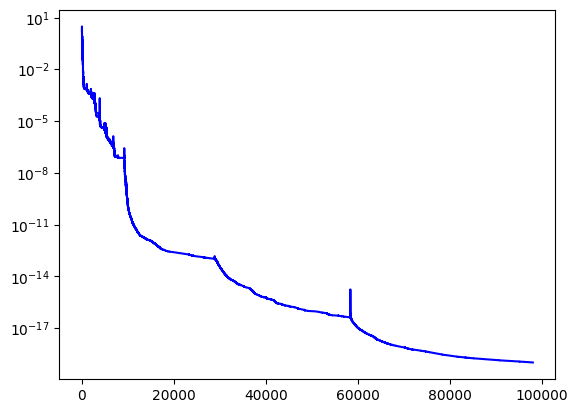

In [7]:
model1, model2, model3, model4 = MSNN.stages[0], MSNN.stages[1], MSNN.stages[2], MSNN.stages[3]
loss = np.array(model1.loss + model2.loss + model3.loss + model4.loss)
plt.figure()
plt.plot(loss, 'b-')
plt.yscale("log")